## Import all the libraries

In [1]:
import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from dask.diagnostics import ProgressBar
from datetime import date
import json
import os
import warnings
import seawater
import re

warnings.filterwarnings('ignore')


## Parameters

In [2]:
ymin=2010;mmin=1;dmin=1
ymax=2010;mmax=4;dmax=30
# depth of the desired comparison profile in m
depthmin=500
# radius of the circle around the profile location in which we take the modeled profiles, in °  
radius_max=0.25
# period of time around the profile sampling date in which we take the modeled profiles, in days
period=5
# minimum amount of model profiles to be considered to make a significant statistical comparison, for instance in a 1° square and 30-days window we have 2.6 millions modeled profiles, in a 0.5°x10 days 216 000
number_of_model_profiles=100000


In [3]:
# Parameters
ymin = 2010
mmin = 1
dmin = 1
ymax = 2010
mmax = 4
dmax = 30
depthmin = 500
radius_max = 0.25
period = 5
number_of_model_profiles = 100000


In [4]:
datemin=datetime.date(ymin,mmin,dmin)
datemax=datetime.date(ymax,mmax,dmax)
jsonfile='txt/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.json'

## Read the jsonfile

In [5]:
sourcefile=open(jsonfile,'rU')
infos=json.load(sourcefile)
nb_profilesEN4=len(infos)


In [6]:
vert_standart=np.array([0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,
                   110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,
                   420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,
                   820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,
                   1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000])
indz=np.where(vert_standart>depthmin)
vert_standart_red=vert_standart[0:np.min(indz[0])-1]

all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))


In [7]:
for prof in np.arange(nb_profilesEN4):
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    print('Processing profile ', reference)
    # Open the netcdf file
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    dsprof=xr.open_dataset(outname)

    depth_en4=dsprof['depth_en4']
    temp_en4=dsprof['temp_profileEN4']
    salt_en4=dsprof['salt_profileEN4']
    mean_temp_model=dsprof['mean_temp_model']
    mean_salt_model=dsprof['mean_salt_model']
    percent10_temp_model=dsprof['percent10_temp_model']
    percent10_salt_model=dsprof['percent10_salt_model']
    percent90_temp_model=dsprof['percent90_temp_model']
    percent90_salt_model=dsprof['percent90_salt_model']
    obs_lat=dsprof['latitude_profileEN4']
    obs_lon=dsprof['longitude_profileEN4']
    obs_time=dsprof['time_profileEN4']
    
    # Project the profile to standart vertical levels
    temp_en4_standart=np.interp(vert_standart_red,depth_en4,temp_en4)
    salt_en4_standart=np.interp(vert_standart_red,depth_en4,salt_en4)
    mean_temp_model_standart=np.interp(vert_standart_red,depth_en4,mean_temp_model)
    mean_salt_model_standart=np.interp(vert_standart_red,depth_en4,mean_salt_model)
    percent10_temp_model_standart=np.interp(vert_standart_red,depth_en4,percent10_temp_model)
    percent10_salt_model_standart=np.interp(vert_standart_red,depth_en4,percent10_salt_model)
    percent90_temp_model_standart=np.interp(vert_standart_red,depth_en4,percent90_temp_model)
    percent90_salt_model_standart=np.interp(vert_standart_red,depth_en4,percent90_salt_model)

    #Fill the all profiles
    all_temp_mean_model[prof,:]=mean_temp_model_standart[:]
    all_salt_mean_model[prof,:]=mean_salt_model_standart[:]
    all_temp_en4[prof,:]=temp_en4_standart[:]
    all_salt_en4[prof,:]=salt_en4_standart[:]
    all_temp_percent10_model[prof,:]=percent10_temp_model_standart[:]
    all_salt_percent10_model[prof,:]=percent10_salt_model_standart[:]
    all_temp_percent90_model[prof,:]=percent90_temp_model_standart[:]
    all_salt_percent90_model[prof,:]=percent90_salt_model_standart[:]


Processing profile  Profile_20100106_prof.nc_71
Processing profile  Profile_20100106_prof.nc_76
Processing profile  Profile_20100108_prof.nc_90
Processing profile  Profile_20100108_prof.nc_92
Processing profile  Profile_20100109_prof.nc_0
Processing profile  Profile_20100109_prof.nc_62
Processing profile  Profile_20100110_prof.nc_0
Processing profile  Profile_20100110_prof.nc_81
Processing profile  Profile_20100113_prof.nc_69
Processing profile  Profile_20100114_prof.nc_3
Processing profile  Profile_20100114_prof.nc_44
Processing profile  Profile_20100115_prof.nc_0
Processing profile  Profile_20100115_prof.nc_58


Processing profile  Profile_20100116_prof.nc_79
Processing profile  Profile_20100118_prof.nc_85
Processing profile  Profile_20100118_prof.nc_88
Processing profile  Profile_20100119_prof.nc_1
Processing profile  Profile_20100119_prof.nc_58
Processing profile  Profile_20100120_prof.nc_0
Processing profile  Profile_20100120_prof.nc_91
Processing profile  Profile_20100123_prof.nc_72
Processing profile  Profile_20100124_prof.nc_42
Processing profile  Profile_20100125_prof.nc_1
Processing profile  Profile_20100125_prof.nc_57
Processing profile  Profile_20100126_prof.nc_69


Processing profile  Profile_20100128_prof.nc_92
Processing profile  Profile_20100128_prof.nc_94
Processing profile  Profile_20100129_prof.nc_0
Processing profile  Profile_20100129_prof.nc_63
Processing profile  Profile_20100130_prof.nc_112
Processing profile  Profile_20100131_prof.nc_83
Processing profile  Profile_20100202_prof.nc_70
Processing profile  Profile_20100203_prof.nc_52
Processing profile  Profile_20100204_prof.nc_0


Processing profile  Profile_20100204_prof.nc_61
Processing profile  Profile_20100205_prof.nc_79
Processing profile  Profile_20100207_prof.nc_87
Processing profile  Profile_20100207_prof.nc_92
Processing profile  Profile_20100208_prof.nc_0
Processing profile  Profile_20100208_prof.nc_61
Processing profile  Profile_20100209_prof.nc_0
Processing profile  Profile_20100209_prof.nc_79
Processing profile  Profile_20100212_prof.nc_77
Processing profile  Profile_20100213_prof.nc_3
Processing profile  Profile_20100213_prof.nc_46
Processing profile  Profile_20100214_prof.nc_57
Processing profile  Profile_20100215_prof.nc_74


Processing profile  Profile_20100215_prof.nc_81
Processing profile  Profile_20100217_prof.nc_101
Processing profile  Profile_20100217_prof.nc_96
Processing profile  Profile_20100218_prof.nc_27
Processing profile  Profile_20100219_prof.nc_0
Processing profile  Profile_20100219_prof.nc_72
Processing profile  Profile_20100219_prof.nc_96
Processing profile  Profile_20100222_prof.nc_71
Processing profile  Profile_20100223_prof.nc_25
Processing profile  Profile_20100223_prof.nc_3
Processing profile  Profile_20100224_prof.nc_58


Processing profile  Profile_20100225_prof.nc_65
Processing profile  Profile_20100225_prof.nc_73
Processing profile  Profile_20100227_prof.nc_100
Processing profile  Profile_20100227_prof.nc_99
Processing profile  Profile_20100228_prof.nc_0
Processing profile  Profile_20100228_prof.nc_59
Processing profile  Profile_20100301_prof.nc_0
Processing profile  Profile_20100301_prof.nc_82
Processing profile  Profile_20100303_prof.nc_38
Processing profile  Profile_20100303_prof.nc_41
Processing profile  Profile_20100304_prof.nc_75


Processing profile  Profile_20100305_prof.nc_2
Processing profile  Profile_20100306_prof.nc_0
Processing profile  Profile_20100306_prof.nc_61
Processing profile  Profile_20100307_prof.nc_69
Processing profile  Profile_20100308_prof.nc_1
Processing profile  Profile_20100308_prof.nc_52
Processing profile  Profile_20100308_prof.nc_63
Processing profile  Profile_20100309_prof.nc_97
Processing profile  Profile_20100310_prof.nc_0
Processing profile  Profile_20100310_prof.nc_49
Processing profile  Profile_20100310_prof.nc_58
Processing profile  Profile_20100311_prof.nc_0


Processing profile  Profile_20100311_prof.nc_80
Processing profile  Profile_20100312_prof.nc_42
Processing profile  Profile_20100312_prof.nc_48
Processing profile  Profile_20100313_prof.nc_0
Processing profile  Profile_20100314_prof.nc_36
Processing profile  Profile_20100314_prof.nc_48
Processing profile  Profile_20100315_prof.nc_0
Processing profile  Profile_20100316_prof.nc_0
Processing profile  Profile_20100316_prof.nc_18
Processing profile  Profile_20100316_prof.nc_61
Processing profile  Profile_20100317_prof.nc_81
Processing profile  Profile_20100319_prof.nc_97
Processing profile  Profile_20100319_prof.nc_99


Processing profile  Profile_20100320_prof.nc_0
Processing profile  Profile_20100321_prof.nc_92
Processing profile  Profile_20100322_prof.nc_60
Processing profile  Profile_20100324_prof.nc_78
Processing profile  Profile_20100325_prof.nc_1
Processing profile  Profile_20100326_prof.nc_0
Processing profile  Profile_20100326_prof.nc_55
Processing profile  Profile_20100327_prof.nc_69
Processing profile  Profile_20100329_prof.nc_91
Processing profile  Profile_20100329_prof.nc_95
Processing profile  Profile_20100330_prof.nc_0
Processing profile  Profile_20100331_prof.nc_0


Processing profile  Profile_20100331_prof.nc_83
Processing profile  Profile_20100403_prof.nc_85
Processing profile  Profile_20100405_prof.nc_0
Processing profile  Profile_20100405_prof.nc_56
Processing profile  Profile_20100405_prof.nc_75
Processing profile  Profile_20100406_prof.nc_68
Processing profile  Profile_20100408_prof.nc_95
Processing profile  Profile_20100408_prof.nc_96
Processing profile  Profile_20100410_prof.nc_0
Processing profile  Profile_20100410_prof.nc_103
Processing profile  Profile_20100410_prof.nc_78


Processing profile  Profile_20100412_prof.nc_0
Processing profile  Profile_20100414_prof.nc_2
Processing profile  Profile_20100415_prof.nc_0
Processing profile  Profile_20100415_prof.nc_65
Processing profile  Profile_20100416_prof.nc_74
Processing profile  Profile_20100418_prof.nc_93
Processing profile  Profile_20100418_prof.nc_96
Processing profile  Profile_20100419_prof.nc_0
Processing profile  Profile_20100420_prof.nc_0
Processing profile  Profile_20100420_prof.nc_74
Processing profile  Profile_20100422_prof.nc_0
Processing profile  Profile_20100424_prof.nc_0
Processing profile  Profile_20100425_prof.nc_0
Processing profile  Profile_20100425_prof.nc_66


In [8]:
mean_all_temp_mean_model=np.mean(all_temp_mean_model,axis=0)
mean_all_salt_mean_model=np.mean(all_salt_mean_model,axis=0)
mean_all_temp_en4=np.mean(all_temp_en4,axis=0)
mean_all_salt_en4=np.mean(all_salt_en4,axis=0)
mean_all_temp_percent10_model=np.mean(all_temp_percent10_model,axis=0)
mean_all_salt_percent10_model=np.mean(all_salt_percent10_model,axis=0)
mean_all_temp_percent90_model=np.mean(all_temp_percent90_model,axis=0)
mean_all_salt_percent90_model=np.mean(all_salt_percent90_model,axis=0)


In [9]:
min_temp=np.nanmin([np.nanmin(mean_all_temp_mean_model),
                 np.nanmin(mean_all_temp_en4),
                 np.nanmin(mean_all_temp_percent10_model),
                 np.nanmin(mean_all_temp_percent90_model)])
max_temp=np.nanmax([np.nanmax(mean_all_temp_mean_model),
                 np.nanmax(mean_all_temp_en4),
                 np.nanmax(mean_all_temp_percent10_model),
                 np.nanmax(mean_all_temp_percent90_model)])
min_salt=np.nanmin([np.nanmin(mean_all_salt_mean_model),
                 np.nanmin(mean_all_salt_en4),
                 np.nanmin(mean_all_salt_percent10_model),
                 np.nanmin(mean_all_salt_percent90_model)])
max_salt=np.nanmax([np.nanmax(mean_all_salt_mean_model),
                 np.nanmax(mean_all_salt_en4),
                 np.nanmax(mean_all_salt_percent10_model),
                 np.nanmax(mean_all_salt_percent90_model)])
print(min_temp,max_temp,min_salt,max_salt)



13.196166441525241 15.21765470418853 37.7210389405298 38.53979215177431


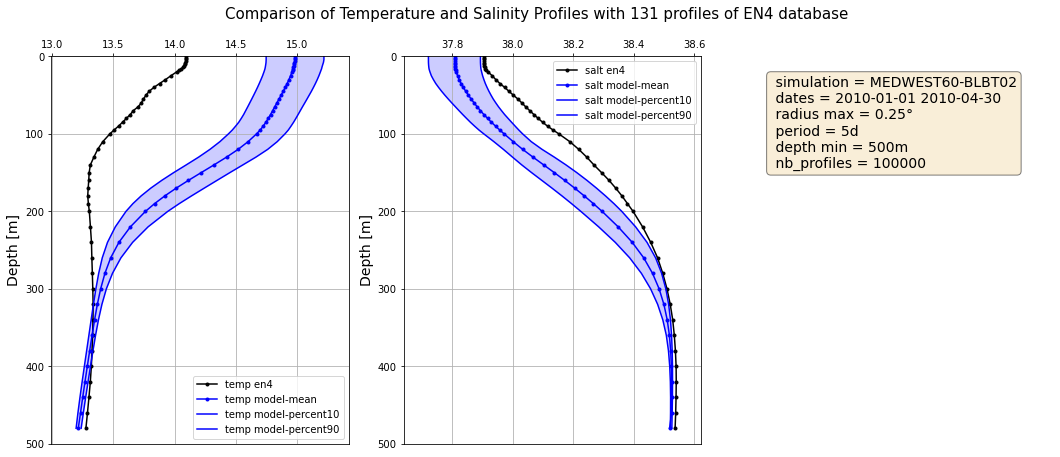

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))
axs = axs.ravel()
title = 'Comparison of Temperature and Salinity Profiles with '+str(nb_profilesEN4)+' profiles of EN4 database'
plt.suptitle(title,size = 15,y=1.05)
axs[0].plot(mean_all_temp_en4,vert_standart_red,'k.-', label='temp en4')
axs[0].plot(mean_all_temp_mean_model,vert_standart_red,'b.-', label='temp model-mean')
axs[0].set_ylabel('Depth [m]', size=14)
axs[0].set_xlim(left=min_temp-(max_temp-min_temp)/10,right=max_temp+(max_temp-min_temp)/10)
axs[0].set_ylim(depthmin, 0)
axs[0].grid(True, which='both')
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top') 
axs[0].plot(mean_all_temp_percent10_model,vert_standart_red,'b-', label='temp model-percent10')
axs[0].plot(mean_all_temp_percent90_model,vert_standart_red,'b-', label='temp model-percent90')
axs[0].fill_betweenx(vert_standart_red, mean_all_temp_percent10_model, x2=mean_all_temp_percent90_model, alpha=0.2, facecolor='b')
#        axs[0].set_title('Temperature profiles')
axs[0].legend()
        
axs[1].plot(mean_all_salt_en4,vert_standart_red,'k.-', label='salt en4')
axs[1].plot(mean_all_salt_mean_model,vert_standart_red,'b.-', label='salt model-mean')
axs[1].set_ylabel('Depth [m]', size=14)
axs[1].set_xlim(left=min_salt-(max_salt-min_salt)/10,right=max_salt+(max_salt-min_salt)/10)
axs[1].set_ylim(depthmin, 0)
axs[1].grid(True, which='both')
axs[1].xaxis.tick_top()
axs[1].xaxis.set_label_position('top') 
axs[1].plot(mean_all_salt_percent10_model,vert_standart_red,'b-', label='salt model-percent10')
axs[1].plot(mean_all_salt_percent90_model,vert_standart_red,'b-', label='salt model-percent90')
axs[1].fill_betweenx(vert_standart_red, mean_all_salt_percent10_model, x2=mean_all_salt_percent90_model, alpha=0.2, facecolor='b')
#        axs[1].set_title('Salinity profiles')
axs[1].legend()

textstr = '\n'.join((
            ' simulation = MEDWEST60-BLBT02',
            ' dates = '+str(datemin)+' '+str(datemax),
            ' radius max = '+str(radius_max)+'°',
            ' period = '+str(period)+'d',
            ' depth min = '+str(depthmin)+'m',
            ' nb_profiles = '+str(number_of_model_profiles)))        
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[2].text(0.05, 0.95, textstr, transform=axs[2].transAxes, fontsize=14,verticalalignment='top', bbox=props)
axs[2].axis('off')
fig.tight_layout()
plt.savefig('plots/profiles-TS-MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.png',bbox_inches='tight')
